In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from skimage.segmentation import find_boundaries

from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap, draw_polygons, sample_points
from stardist import Config, StarDist

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [2]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [3]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x,cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load StarDist models

We assume that two StarDist models have already been trained via notebook [2_training.ipynb](2_training.ipynb).

In [4]:
# Without shape completion
model_no_sc = StarDist(None, name='stardist_no_shape_completion', basedir='models')

Instructions for updating:
Colocations handled automatically by placer.
Loading network weights from 'weights_best.h5'.


In [5]:
# With shape completion
model_sc = StarDist(None, name='stardist_shape_completion', basedir='models')

Loading network weights from 'weights_best.h5'.


## Prediction

1. Load image and normalize
2. Predict object `prob`abilities and star-convex polygon `dist`ances
3. Convert `dist`ances to polygon vertex `coord`inates
4. Perform non-maximum suppression for polygons above object probability threshold
5. Convert final polygons to label instance image

In [6]:
img = normalize(X[16],1,99.8,axis=axis_norm)
prob, dist = model_sc.predict(img)
coord = dist_to_coord(dist)
points = non_maximum_suppression(coord,prob,prob_thresh=0.4)
labels = polygons_to_label(coord,prob,points)


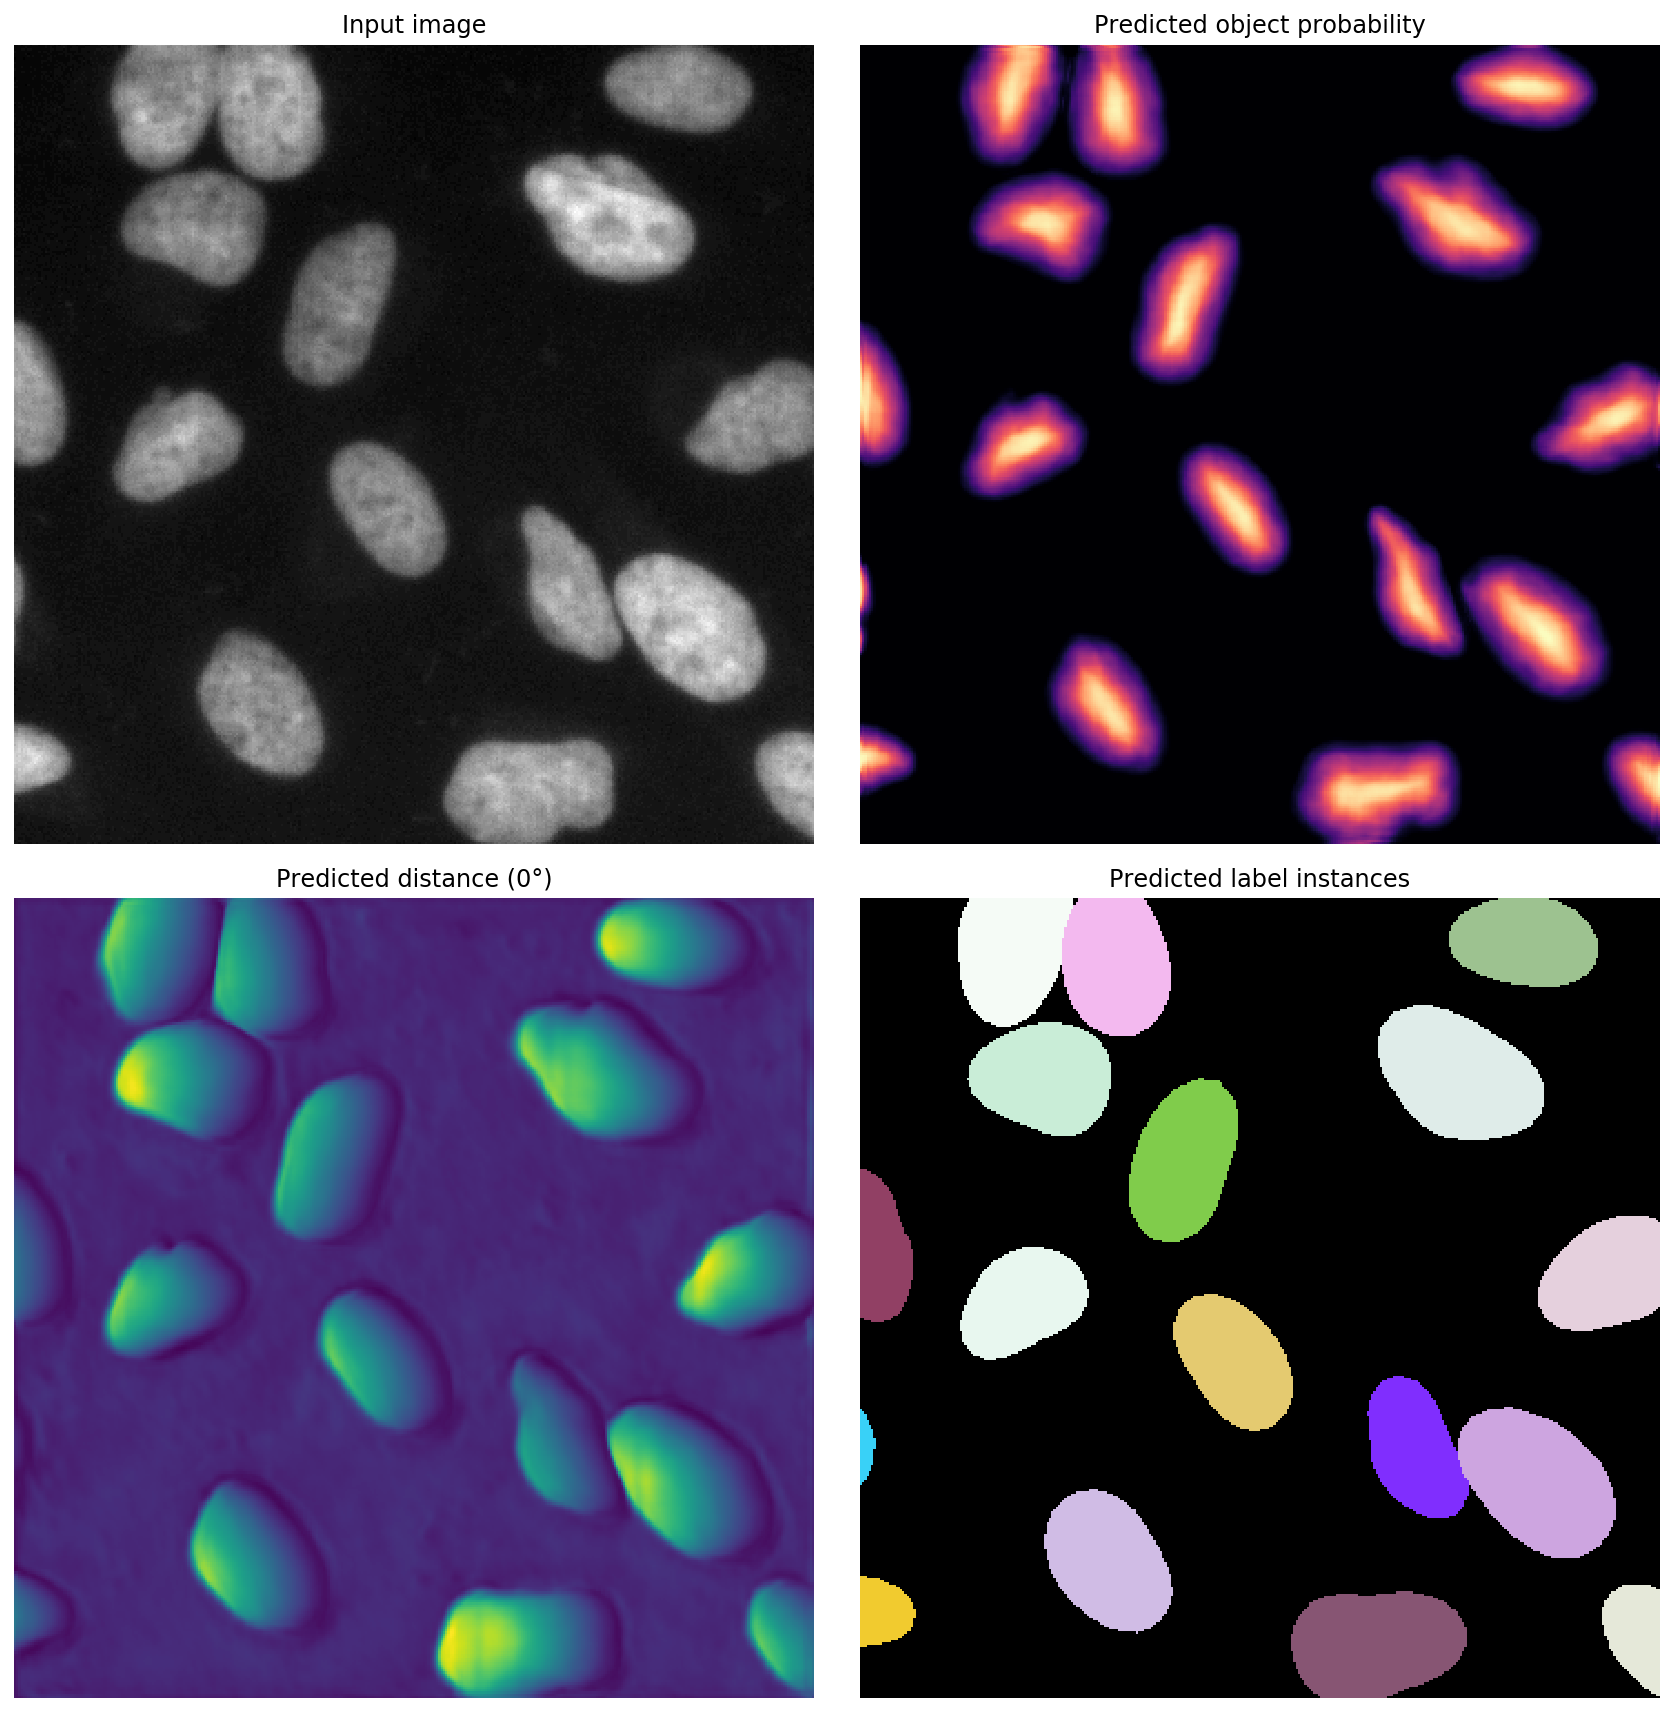

In [7]:
img_show = img if img.ndim==2 else img[...,0]
fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img_show,prob,dist[...,0],labels], ['gray','magma','viridis',lbl_cmap],
                    ['Input image','Predicted object probability','Predicted distance (0°)','Predicted label instances']):
    a.imshow(d,cmap=cm)
    a.set_title(s)
    a.axis('off')
plt.tight_layout()
None;

In [8]:
from foolbox.models import KerasModel
import keras.backend as K

predictions = model_sc.keras_model.output
print(K.int_shape(predictions[-1]))
   
model = KerasModel(model_sc.keras_model,bounds=(0, 255))

(None, None, None, 32)


AttributeError: 'list' object has no attribute 'op'

In [ ]:
plt.figure(figsize=(13,12))
points_rnd = sample_points(200,prob>0.2)
plt.subplot(121); plt.imshow(img_show,cmap='gray'); draw_polygons(coord,prob,points_rnd,cmap=lbl_cmap)
plt.axis('off'); plt.title('Polygons randomly sampled')
plt.subplot(122); plt.imshow(img_show,cmap='gray'); draw_polygons(coord,prob,points,cmap=lbl_cmap)
plt.axis('off'); plt.title('Polygons after non-maximum suppression')
plt.tight_layout()
None;

# Comparing results with and without shape completion

In [ ]:
def example(model,i):
    img = normalize(X[i],1,99.8,axis=axis_norm)
    prob, dist = model.predict(img)
    coord = dist_to_coord(dist)
    points = non_maximum_suppression(coord,prob,prob_thresh=0.4)
    labels = polygons_to_label(coord,prob,points)

    img_show = img if img.ndim==2 else img[...,0]
    plt.figure(figsize=(13,10))
    plt.subplot(121); plt.imshow(img_show,cmap='gray'); plt.axis('off')
    draw_polygons(coord,prob,points,show_dist=True)
    if model in (model_no_sc,model_sc):
        plt.title(('With' if model==model_sc else 'Without') + ' shape completion')
    plt.subplot(122); plt.imshow(img_show,cmap='gray'); plt.axis('off')
    plt.imshow(labels,cmap=lbl_cmap,alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
example(model_no_sc,42)
example(model_sc,42)

In [ ]:
example(model_no_sc,1)
example(model_sc,1)

In [ ]:
example(model_no_sc,15)
example(model_sc,15)

# Model from paper

In [ ]:
model_paper = StarDist(None, name='dsb2018', basedir='../models')
model_paper.load_weights('weights_last.h5')

In [ ]:
example(model_paper,29)